<a href="https://colab.research.google.com/github/alimomennasab/CS4210/blob/main/4210FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS4210-02 Machine Learning
## Fall 2024 Semester Project
Convolutional neural network model that classifies fish/shrimp from an image
### Members:
- Ali Momennasab
- Denise Thuong
- Eli Tolentino
- Armin Erika Polanco
- Sarah Choe
- Damian Varela


Imports

In [4]:
!pip install torchview


import kagglehub
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
import PIL
from pathlib import Path

Data Preprocessing

In [5]:
# Download latest version
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2


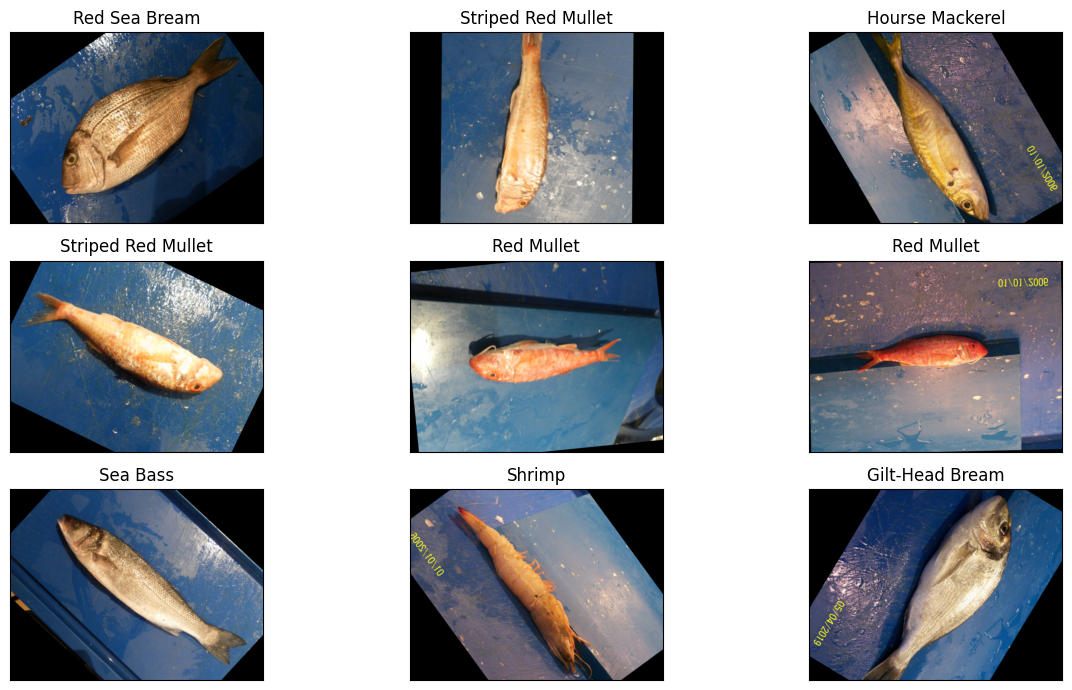

In [6]:
# Cleaning dataset

direc = Path(path)
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)

img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ] # ground truth binary masks not needed for classification

img_df = img_df[img_df['FilePaths'].str.endswith('.png')].reset_index(drop=True) # keep only pngs

# Resampling it (elaborate?)
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()

In [7]:
# Data analysis
img_df.shape

(9281, 2)

In [8]:
# Data analysis
img_df.columns

Index(['FilePaths', 'Labels'], dtype='object')

In [9]:
# Checking to see if all images have the same resolution
shape_counts = {}

for idx, filepath in enumerate(img_df.FilePaths):
    try:
        img = PIL.Image.open(filepath)
        shape = np.array(img).shape

        # Store the count of each shape
        if shape in shape_counts:
            shape_counts[shape] += 1
        else:
            shape_counts[shape] = 1

    except:
      img_df.drop(idx, inplace=True)

print("Image shape distribution:")
for shape, count in shape_counts.items():
    print(f"Shape {shape}: {count} images")

Image shape distribution:
Shape (445, 590, 3): 9000 images
Shape (768, 1024, 3): 178 images
Shape (2128, 2832, 3): 103 images


In [10]:
# Delete original, non-augmented photos that have different sizing/resolution
for index in img_df.index:
    try:
        img = plt.imread(img_df.FilePaths[index])
        if img.shape != (445, 590, 3):
            img_df.drop(index, inplace=True)
    except:
        # If we can't read the image, drop it
        img_df.drop(index, inplace=True)

img_df.shape

(9000, 2)

In [11]:
# Split 9k image dataset into 8k training and 1k testing
train_df, test_df = train_test_split(img_df, train_size=8000, random_state=1)
print("training df shape: " + str(train_df.shape))
print("test_df.shape: " + str(test_df.shape))

# Getting labels
train_labels = train_df.Labels
test_labels = test_df.Labels

# Use data generator for training data to save memory
datagen = ImageDataGenerator()
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="FilePaths",
    y_col="Labels",
    batch_size=32,
    target_size=(445, 590),
    class_mode='categorical')

training df shape: (8000, 2)
test_df.shape: (1000, 2)
Found 8000 validated image filenames belonging to 9 classes.


Model Implementation

In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(445, 590, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(img_df.Labels.unique()), activation='softmax')  # number of fish classes
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 443, 588, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 221, 294, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 219, 292, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 109, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 107, 144, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 53, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 51, 70, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 25, 35, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 23, 33, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 11, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 22528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,441,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,720,201 (6.56 MB)

 Trainable params: 1,720,201 (6.56 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [13]:
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

model.fit(train_generator, epochs=20, verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 478ms/step - accuracy: 0.2023 - loss: 4.2902
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 124s 481ms/step - accuracy: 0.4264 - loss: 1.5540
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 123s 480ms/step - accuracy: 0.6903 - loss: 0.8511
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 479ms/step - accuracy: 0.8231 - loss: 0.4923
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 477ms/step - accuracy: 0.9082 - loss: 0.2723
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 123s 479ms/step - accuracy: 0.9421 - loss: 0.1864
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 123s 481ms/step - accuracy: 0.9498 - loss: 0.1512
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 123s 476ms/step - accuracy: 0.9693 - loss: 0.0910
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 475ms/step - accuracy: 0.9771 - loss: 0.0649
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 122s 478ms/step - accuracy: 0.9703 - loss: 0.0897
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 479ms/step - accuracy: 0.9854 - loss: 0.0469
Epoch 12/20
250/250

In [15]:
model.save('fish_model.keras')